# Dielectric Properties of Natural Media

In this notebook we want to look at how different surfaces like water, forest grasland and cities give us different backscatter.

We are going to load backscatering data from Sentinel 1 and we will use the Corine Landcoverdata to get a classification of different surfaces.

TODO:
include time series - how much data changes over time or is affected by certain weather

## Import packages

In [185]:
# tidy up!

import os
import xarray as xr
import rioxarray
import rasterio
import numpy as np
from rasterio.crs import CRS
import dask.array as da
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import folium
import matplotlib.patches as patches
from datetime import datetime
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from pyproj import Transformer


## Load Sentinel 1 data

Load Metadata to get some information on the data. Using '.tags()' we can extract a lot of useful information like the scale_factor.

As we can see frome here the data was captured 8 images between the 5th August 2023 and the 28th October 2023. The image contains Gamma VV values.

Now we can load the data and and apply preprocessing. From the Metaddata we could extract a scalingfactor of 100 which we now need to apply.

We get a xarray.DataSet and convert it to an xarray.DataArray because we only have one variable, the VV backscatter.

We have 8 timestemps. For performance reasons we will fous on only on one time becasue the data does not change to much over time.

We downsample already in the preprocessing because we do not need all the resolution because we are working with the corine data map and the resolution there is 100 by 100 meters. When we downsample x and y coordinates by 10 we get pixles of size 100 by 100meters which fits perfectly to the 

(insert image of downscaled, normal and corine landcover)

In [186]:
#sig0_ds_large = rioxarray.open_rasterio(     is this the preferred way?


data_path = Path('~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler').expanduser() # SAT-1 data is inside the saocom_gamma folder but this could change
tif_files = glob(f"{data_path}/*.tif")

def _preprocess(x):
    file = x.encoding['source']
    print(f"{os.path.basename(file)}: {rasterio.open(file).tags()}")    # is rasterio ok?

    scale_factor = pd.to_numeric(
        rasterio.open(x.encoding["source"]).tags().get('scale_factor')
    )

    time_value = pd.to_datetime(
        rasterio.open(x.encoding["source"]).tags().get('time_begin')
    )
    x = x / scale_factor
    x = x.assign_coords(time=time_value).expand_dims("time")
    
    return x.squeeze("band").drop_vars("band")

sig0_ds_large = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)


sig0_ds = sig0_ds_large.sel(
    x=slice(5_280_000.0, 5_295_000.0), 
    y=slice(1_570_000.0, 1_560_000.0)
    )

#sig0_time_ds = sig0_ds[list(sig0_ds.data_vars.keys())[0]]
#sig0_ds = sig0_ds[list(sig0_ds.data_vars.keys())[0]] .isel(time=0)
sig0_ds = sig0_ds[list(sig0_ds.data_vars.keys())[0]].mean(dim='time').compute()

sig0_ds

D20230805_165122--_GMR------_S1AIWGRDH1VVA_146_A0105_EU010M_E052N015T1.tif: {'abs_orbit_number': '049743', 'band_1': 'Gamma0_VV', 'border_noise_removed': 'True', 'creator': 'TUWGEO', 'distanceuom': 'm', 'distancevalue': '10', 'equi7_tile': 'EU010M_E052N015T1', 'ext_dem': '/eodc/private/tuwgeo/users/acube/data/input/acube_dem_eh.tif', 'grid': 'Equi7 Grid', 'gtc_applied': 'True', 'log_file': 'tasklist_2_A01_gmr_jobfile_A0105_log_20231201_034630.xml', 'orbit_aux_file': 'POE', 'parent_data_file': 'S1A_IW_GRDH_1SDV_20230805T165122_20230805T165147_049743_05FB3C_64DB.zip', 'polarisation': 'VV', 'precise_orbit_applied': 'True', 'processing_date': '2023-12-01 03:46:31', 'processing_software': 'SGRT', 'processing_software_version': 'A0105-2.4.9.post.dev6.pre', 'rel_orbit_number': '146', 'rtf_applied': 'True', 'sat_product_id': 'S1AIWGRDH1VVA', 'scale_factor': '100.0', 'thermal_noise_removed': 'True', 'time_begin': '2023-08-05 16:51:22', 'time_end': '2023-08-05 16:51:47', 'variable_name': 'GMR', 

<xarray.DataArray 'band_data' (y: 1000, x: 1500)> Size: 12MB
array([[-13.80499983, -13.8599999 , -12.58875   , ..., -21.56625009,
        -22.39249992, -21.15875006],
       [-13.88499999, -14.20375025, -13.45375013, ..., -22.2037499 ,
        -23.00500035, -23.11124992],
       [-13.67875004, -13.32249987, -13.08249986, ..., -22.72000003,
        -23.90124989, -23.67624998],
       ...,
       [-10.71500003, -10.37375003, -10.07625002, ..., -11.82749999,
        -11.27374983, -10.9425    ],
       [-11.54375005, -10.2924999 ,  -8.79250002, ..., -11.42500007,
        -11.18000007, -11.41374993],
       [-12.28250003, -11.41625005,  -9.03875011, ..., -11.43000007,
        -11.69874978, -12.33124995]])
Coordinates:
  * x            (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y            (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref  int64 8B 0

To get an idea of the region we are looking at we want to display it. Using 'rubust=True' will use the 2nd and 98th percentiles of the data to compute the color limits. 

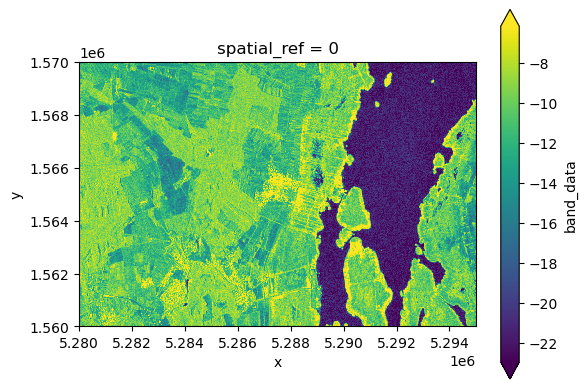

In [187]:
sig0_ds.plot(robust=True).axes.set_aspect('equal')

## Load Corine Landcover data

We load the Corine Land Cover data which classifies the landcover of europa in 44 different areas.

We want to work with the Equi7 grid because it preserves geometric accuracy and minimises data oversampling over surfaces. So we need to convert the Corine Land Cover map to this coordinate system.

### Loading data
maybe load and clip together?

In [188]:
tif_path = Path('~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif').expanduser()

metadata = rasterio.open(tif_path).meta
print(metadata)

corine_ds_large = xr.open_dataset(tif_path,engine="rasterio")

corine_ds_large = corine_ds_large["band_data"].squeeze()
corine_ds_large

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -128.0, 'width': 65000, 'height': 46000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(100.0, 0.0, 900000.0,
       0.0, -100.0, 5500000.0)}


<xarray.DataArray 'band_data' (y: 46000, x: 65000)> Size: 12GB
[2990000000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 520kB 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 368kB 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 8B ...
Attributes:
    DataType:                Thematic
    AREA_OR_POINT:           Area
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836

### Colormapping and Encoding

In [189]:
# mapping from https://collections.sentinel-hub.com/corine-land-cover/readme.html

color_mapping = {
    1: ("#e6004d", "Continuous urban fabric"),
    2: ("#ff0000", "Discontinuous urban fabric"),
    3: ("#cc4df2", "Industrial or commercial units"),
    4: ("#cc0000", "Road and rail networks and associated land"),
    5: ("#e6cccc", "Port areas"),
    6: ("#e6cce6", "Airports"),
    7: ("#a600cc", "Mineral extraction sites"),
    8: ("#a64d00", "Dump sites"),
    9: ("#ff4dff", "Construction sites"),
    10: ("#ffa6ff", "Green urban areas"),
    11: ("#ffe6ff", "Sport and leisure facilities"),
    12: ("#ffffa8", "Non-irrigated arable land"),
    13: ("#ffff00", "Permanently irrigated land"),
    14: ("#e6e600", "Rice fields"),
    15: ("#e68000", "Vineyards"),
    16: ("#f2a64d", "Fruit trees and berry plantations"),
    17: ("#e6a600", "Olive groves"),
    18: ("#e6e64d", "Pastures"),
    19: ("#ffe6a6", "Annual crops associated with permanent crops"),
    20: ("#ffe64d", "Complex cultivation patterns"),
    21: ("#e6cc4d", "Land principally occupied by agriculture with significant areas of natural vegetation"),
    22: ("#f2cca6", "Agro-forestry areas"),
    23: ("#80ff00", "Broad-leaved forest"),
    24: ("#00a600", "Coniferous forest"),
    25: ("#4dff00", "Mixed forest"),
    26: ("#ccf24d", "Natural grasslands"),
    27: ("#a6ff80", "Moors and heathland"),
    28: ("#a6e64d", "Sclerophyllous vegetation"),
    29: ("#a6f200", "Transitional woodland-shrub"),
    30: ("#e6e6e6", "Beaches - dunes - sands"),
    31: ("#cccccc", "Bare rocks"),
    32: ("#ccffcc", "Sparsely vegetated areas"),
    33: ("#000000", "Burnt areas"),
    34: ("#a6e6cc", "Glaciers and perpetual snow"),
    35: ("#a6a6ff", "Inland marshes"),
    36: ("#4d4dff", "Peat bogs"),
    37: ("#ccccff", "Salt marshes"),
    38: ("#e6e6ff", "Salines"),
    39: ("#a6a6e6", "Intertidal flats"),
    40: ("#00ccf2", "Water courses"),
    41: ("#80f2e6", "Water bodies"),
    42: ("#00ffa6", "Coastal lagoons"),
    43: ("#a6ffe6", "Estuaries"),
    44: ("#e6f2ff", "Sea and ocean"),
    48: ("#ffffff", "NODATA")
}

colors = [color for color, _ in color_mapping.values()]
categories = [key for key in color_mapping.keys()]

handles = [
    mpatches.Patch(color=color, label=f'{key} - {label}') 
    for key, (color, label) in color_mapping.items()
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(categories + [max(categories) + 1], len(categories))

### Select area of interest

In [190]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

bbox_27704 = sig0_ds.rio.transform_bounds(sig0_ds_large.rio.crs)
bbox_3035 = transformer.transform_bounds(*bbox_27704)

print(bbox_27704)
print(bbox_3035)

x_min, y_min, x_max, y_max = bbox_3035
corine_ds = corine_ds_large.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

(5280000.0, 1560000.0, 5295000.0, 1570000.0)
(4812114.118336652, 2753663.067999402, 4828666.887941091, 2766310.2777903196)


### Alignment of the datasets (raster + pixles)

In [191]:
def print_details(ds, ds_name):
    print(f"{ds_name}:")
    print(f"CRS: {ds.rio.crs}")
    print(f"Bounds: {ds.rio.bounds()}")
    print(f"Pixel size: {ds.rio.resolution()}\n")

In [192]:
print_details(corine_ds, "corine_ds")
print_details(sig0_ds, "sig0_ds")

corine_ds:
CRS: PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
Bounds: (4812100.0, 2753700.0, 4828700.0, 2766300.0)
Pixel size: (100.0, -100.0)

sig0_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)



Reprojecting does a whole lot for us

In [193]:
corine_ds = corine_ds.rio.reproject_match(sig0_ds)

print_details(corine_ds, "corine_ds")
print_details(sig0_ds, "sig0_ds")

corine_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)

sig0_ds:
CRS: EPSG:27704
Bounds: (5280000.0, 1560000.0, 5295000.0, 1570000.0)
Pixel size: (10.0, -10.0)



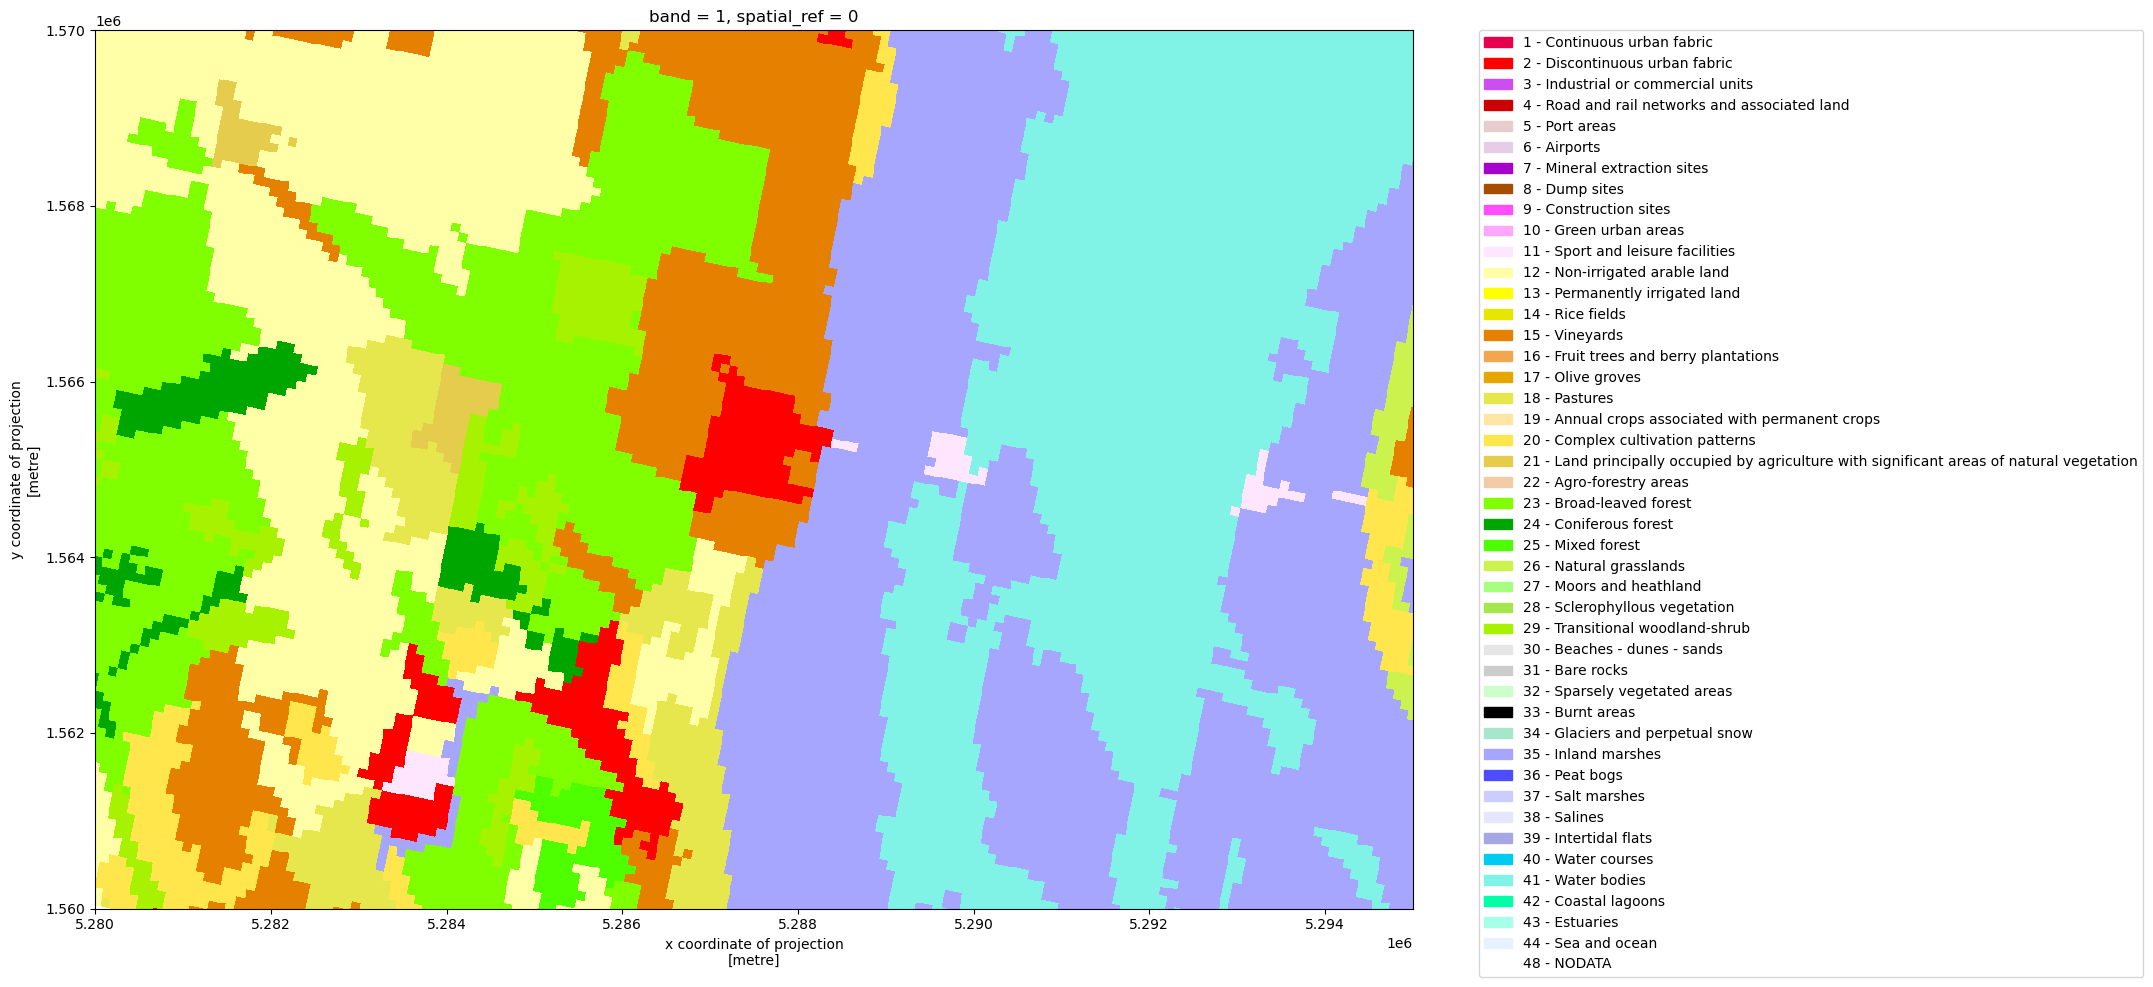

In [194]:
corine_ds.plot(figsize=(17, 12), cmap=cmap, norm=norm, add_colorbar=False).axes.set_aspect('equal')
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Now we can combine the datasets to one xarray dataset.

In [195]:
fused_ds = xr.Dataset({
    'sig0_band_data': sig0_ds,
    'corine_band_data': corine_ds
})
fused_ds

<xarray.Dataset> Size: 18MB
Dimensions:           (x: 1500, y: 1000)
Coordinates:
  * x                 (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y                 (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref       int64 8B 0
    band              int64 8B 1
Data variables:
    sig0_band_data    (y, x) float64 12MB -13.8 -13.86 -12.59 ... -11.7 -12.33
    corine_band_data  (y, x) float32 6MB 12.0 12.0 12.0 12.0 ... 35.0 35.0 35.0

### We create a Histogram for a specific landcover backscatter

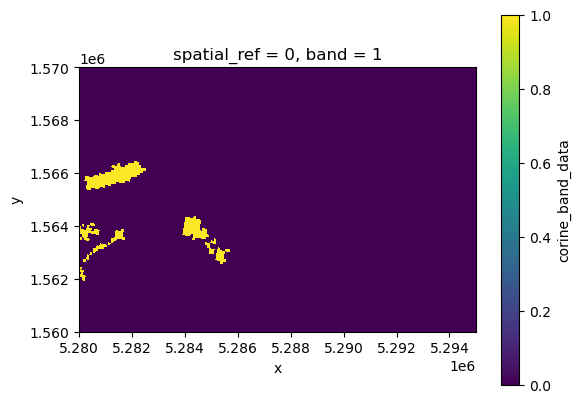

In [196]:
coniferious_forest_mask = (fused_ds["corine_band_data"] == 24)

coniferious_forest_mask.plot().axes.set_aspect('equal')

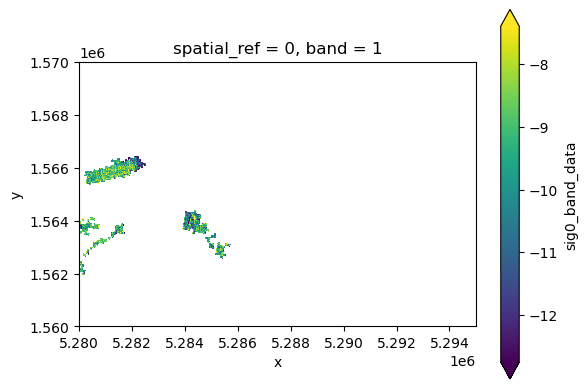

In [197]:
coniferious_forest_backscatter = fused_ds["sig0_band_data"].where(coniferious_forest_mask)
coniferious_forest_backscatter.plot(robust=True).axes.set_aspect('equal')

(array([4.000e+00, 9.000e+00, 1.700e+01, 2.900e+01, 6.100e+01, 1.110e+02,
        2.200e+02, 3.680e+02, 5.640e+02, 1.001e+03, 1.756e+03, 2.952e+03,
        4.542e+03, 5.627e+03, 4.671e+03, 2.739e+03, 9.840e+02, 2.970e+02,
        5.900e+01, 7.000e+00]),
 array([-16.83500016, -16.27125015, -15.70750014, -15.14375013,
        -14.58000013, -14.01625012, -13.45250011, -12.8887501 ,
        -12.3250001 , -11.76125009, -11.19750008, -10.63375007,
        -10.07000006,  -9.50625006,  -8.94250005,  -8.37875004,
         -7.81500003,  -7.25125003,  -6.68750002,  -6.12375001,
         -5.56      ]),
 <BarContainer object of 20 artists>)

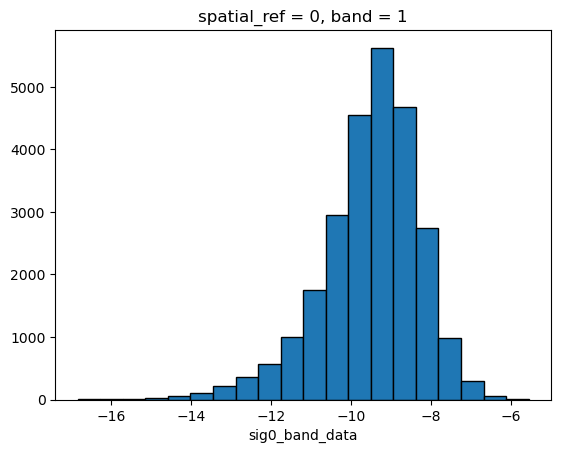

In [198]:
coniferious_forest_backscatter.plot.hist(bins=20, edgecolor='black')

## Function for plotting

In [199]:
def calc_histogram(ds_corine, ds_backscatter, feature_codes):

    all_backscatter_values = []
    mean_var = {}

    for code in feature_codes:
        if code not in color_mapping:
            print(f"Feature code {code} is not in the color mapping.")
            break
        
        mask = (ds_corine == code)

        backscatter_values = ds_backscatter.where(mask, drop=True).values.flatten()
        backscatter_values = backscatter_values[~np.isnan(backscatter_values)]
        
        if len(backscatter_values) == 0:
            continue 
        
        all_backscatter_values.extend(backscatter_values)

        mean_value = np.mean(backscatter_values)
        variance_value = np.var(backscatter_values)

        mean_var[code] = {
            'mean': mean_value,
            'variance': variance_value
        }

    global_min = np.min(all_backscatter_values)
    global_max = np.max(all_backscatter_values)

    return global_min, global_max, mean_var

def plot_mask(ax, mask, feature_name):
    mask.plot(ax=ax)
    ax.set_title(f"{feature_name} Mask")
    ax.set_xlabel('x coordinate [meter]', labelpad=10)
    ax.set_ylabel('y coordinate [meter]', labelpad=10)
    ax.set_aspect('equal')

def plot_backscatter(ax, backscatter, feature_name):
    backscatter.plot(ax=ax, robust=True)
    ax.set_title(f"{feature_name} Backscatter")
    ax.set_xlabel('x coordinate [meter]', labelpad=10)
    ax.set_ylabel('y coordinate [meter]', labelpad=10)
    ax.set_aspect('equal')
    cbar = ax.collections[0].colorbar
    cbar.set_label('Backscatter Value (dB)', labelpad=10)

def plot_histogram(ax, backscatter, feature_name, x_min, x_max, mean_var):
    num_bins = int(np.ceil((x_max - x_min)))
    bin_edges = np.linspace(x_min, x_max, num_bins + 1)
    
    text_str = f"Mean: {mean_var['mean']:.2f}\nVariance: {mean_var['variance']:.2f}"

    backscatter.plot.hist(ax=ax, bins=bin_edges, edgecolor='black')
    ax.set_title(f"{feature_name} Backscatter Histogram")
    ax.set_xlabel('Backscatter Value')
    ax.set_ylabel('Frequency')
    ax.set_xlim(x_min, x_max)
    ax.text(0.95, 0.95, text_str, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))


def plot_classes(ds_corine, ds_backscatter, feature_codes):
    
    x_min, x_max, mean_var = calc_histogram(ds_corine, ds_backscatter, feature_codes)

    n_rows = len(feature_codes)
    n_cols = 3
    
    axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))[1].flatten()

    for idx, code in enumerate(feature_codes):

        feature_name = color_mapping[code][1]

        # mask
        mask = (ds_corine == code).persist()      #.compute()    # a little bit faster with .compute()
        plot_mask(axes[idx * 3], mask, feature_name)


        # backscatter
        feature_backscatter = ds_backscatter.where(mask)
        plot_backscatter(axes[idx * 3 + 1], feature_backscatter, feature_name)


        # histogramm
        plot_histogram(axes[idx * 3 + 2], feature_backscatter, feature_name, x_min, x_max, mean_var[code])
        

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

The function can be used to plot the mask, the actuall backscatter and the histogram of the backscattering values of the corresponding landtype.
Be careful! Dont forget the frequency count on the y axis. They are different form each plot.

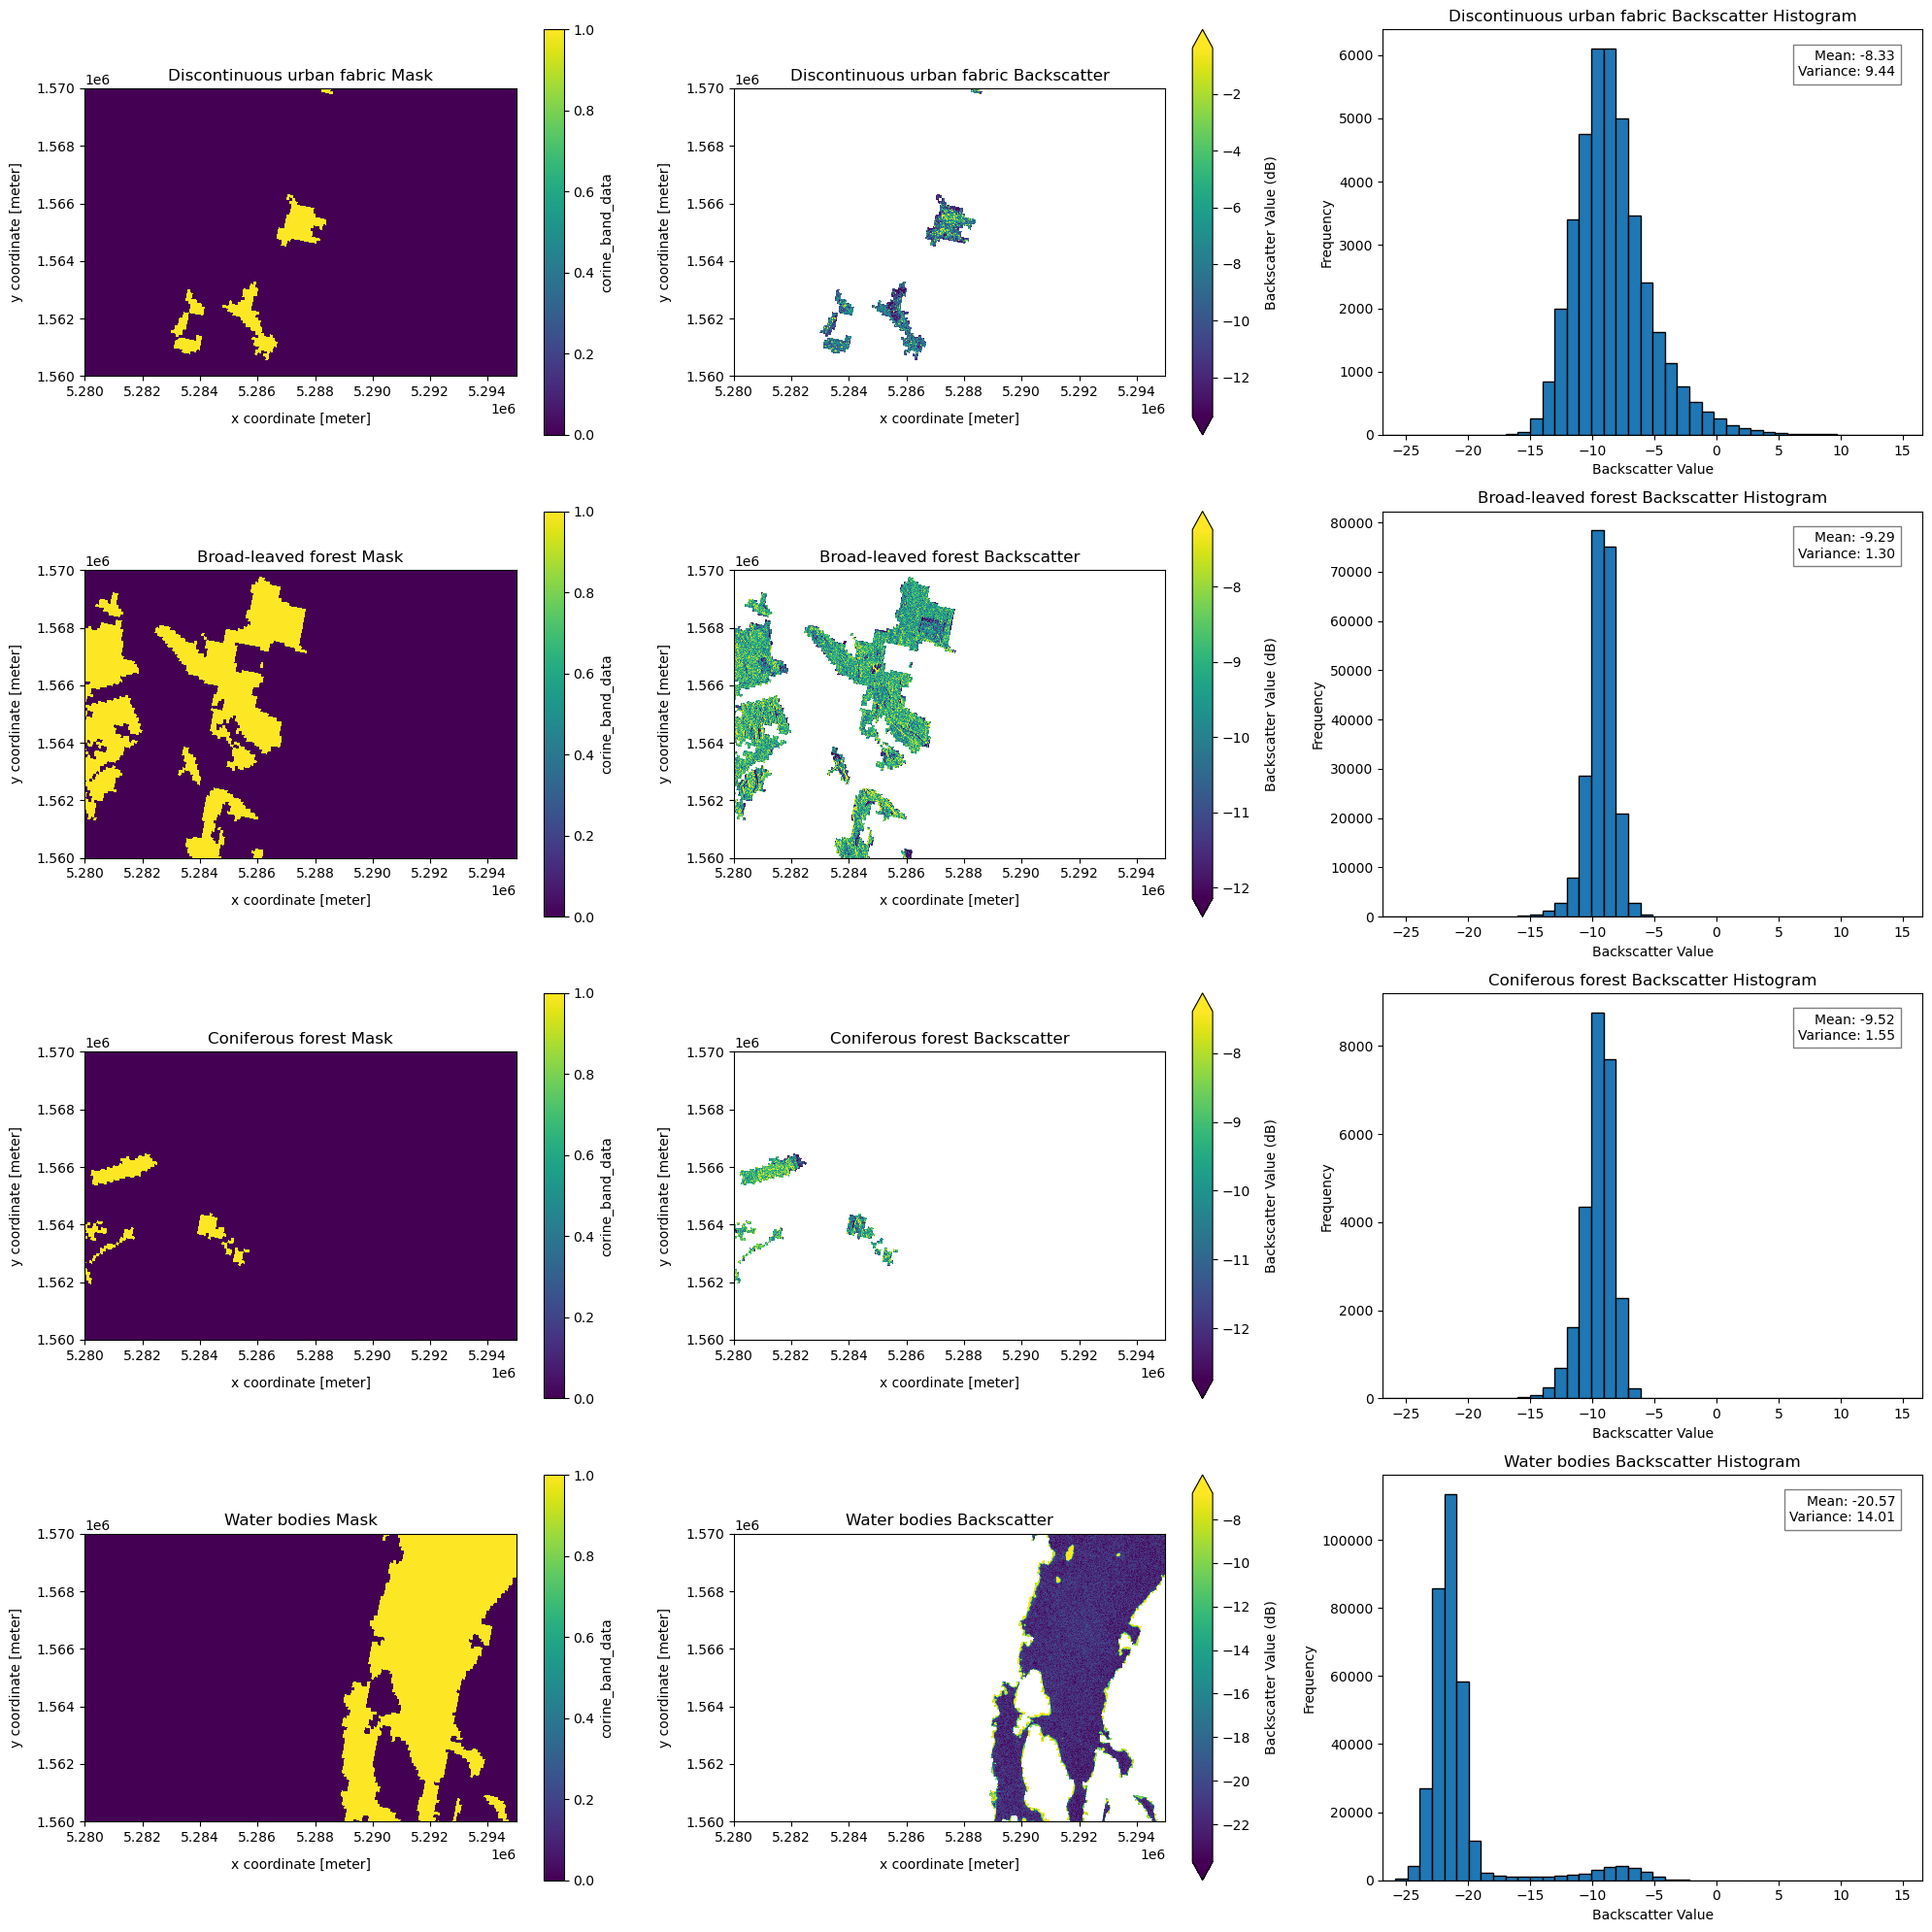

In [200]:
feature_codes = [2,23,24,41]
#feature_codes = [2,41]

plot_classes(fused_ds["corine_band_data"], fused_ds["sig0_band_data"], feature_codes)

# Code not curently used ------------------------------------------

In [58]:
continous_urban_fabric_mask = (ds_corine == 1)
coniferous_forest_mask = (ds_corine == 24)
inland_marshes_mask = (ds_corine == 37)
water_bodies_mask = (ds_corine == 41)

In [ ]:
coniferious_forest_mask['band_data'].plot(add_colorbar=False, figsize=(15, 10)).axes.set_aspect('equal')

In [ ]:
water_bodies_mask['band_data'].plot(add_colorbar=False, figsize=(15, 10)).axes.set_aspect('equal')

In [53]:
# apply mask to backscatter data

water_bodies_backscatter = ds_backscatter_match.where(water_bodies_mask)
coniferious_forest_backscatter = ds_backscatter_match.where(coniferious_forest_mask)

In [ ]:
water_bodies_backscatter['band_data'].plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

In [ ]:
coniferious_forest_backscatter['band_data'].plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

In [ ]:
coniferious_forest_backscatter['band_data'].plot(figsize=(15, 10), robust=True).axes.set_aspect('equal')

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10), cmap=cmap, norm= norm).axes.set_aspect('equal')

### Convert the Box to 3035
The Sentinel data is in EPSG:27704. So we need to reproject the box to the coordinate system of the Corine Landcover data which has EPSG:3035.

In [ ]:
from shapely.geometry import box
from pyproj import Transformer

old_bbox_27704 = ds.rio.transform_bounds(ds.rio.crs)


transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

min_x_3035, min_y_3035 = transformer.transform(old_bbox_27704[0], old_bbox_27704[1])
max_x_3035, max_y_3035 = transformer.transform(old_bbox_27704[2], old_bbox_27704[3])

old_clip_bbox_3035 = box(min_x_3035, min_y_3035, max_x_3035, max_y_3035)

coords = list(clip_bbox_3035.exterior.coords)
coords

In [ ]:
ds_corine_bounded = ds_corine.rio.clip([clip_bbox_3035], crs=ds_corine.rio.crs, drop=True).squeeze()
ds_corine_bounded

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10))

In [ ]:
ds_corine_bounded['band_data'].plot(figsize=(15, 10), cmap="terrain").axes.set_aspect('equal')

In [ ]:
# load new data and only take the area we want

def clip_dataset_to_shape_file(ds, clip_shape_file="'~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif'"):
    bbox = ds.rio.transform_bounds("EPSG:4326")
    clip_shape = gpd.read_file(clip_shape_file).cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    ds = ds.rio.clip(clip_shape.geometry.apply(mapping), clip_shape.crs, invert=False)
    return ds

In [ ]:
xslice = ds_corine['band_data'].coords['x']
yslice = ds_corine['band_data'].coords['y']

len(yslice)

In [ ]:
test = ds_corine['band_data'].isel(x=slice(52_000, 52_100), y=slice(15_000, 15_100))#.squeeze()
test

In [ ]:
test.plot()

### Plot all in low resolution

In [ ]:
ds_corine_downscaled = ds_corine.coarsen(x=1000, y=1000, boundary='pad').mean()
ds_corine_downscaled = ds_corine_downscaled.chunk({"x": 100, "y": 100})
ds_corine_downscaled

### Transform the areas to the different coordinate system

In [ ]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

In [ ]:
area_corine_dataarrays = {}

for area in converted_areas:
    roi = ds_corine.sel(
        x=slice(area['x_min'], area['x_max']),
        y=slice(area['y_max'], area['y_min'])
    )    
    area_corine_dataarrays[area['name']] = roi

ds_corine_area1 = area_corine_dataarrays['area1']
ds_corine_area2 = area_corine_dataarrays['area2']

ds_corine_area2.plot.scatter()

## Plotting in the EPSG:27704
In the EPSG:27704 coordinate system (plotting is quite slow):

## Get the overlapping area

In [ ]:
data_vars = list(ds_WGS84.data_vars)

ds_overlapping = ds_WGS84[data_vars[0]]  # Start with the first variable

for var in data_vars[1:]:
    next_image = ds_WGS84[var]
    ds_overlapping = ds_overlapping.rio.clip_box(*next_image.rio.bounds())

To reduce the runtime we downsample the data to make the plotting faster.

In [ ]:
ds_downsampled = ds_WGS84.isel().coarsen(x=10, y=10, boundary='pad').mean()
ds_overlapping_downsampled = ds_overlapping.isel().coarsen(x=10, y=10, boundary='pad').mean()

In [ ]:
ds_downsampled[data_vars[0]].plot()

In [ ]:
ds_overlapping_downsampled.plot()

We transform our Data to the EPSG:4326 coordinate system which uses Latitude and Longitude values.

In [ ]:
ds_WGS84 = ds.rio.reproject("EPSG:4326")
ds_WGS84

In [ ]:
# corine transformation

bbox_27704 = sig0_ds.rio.transform_bounds(sig0_ds.rio.crs)

transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

bbox_3035 = transformer.transform_bounds(*bbox_27704)

x_min, y_min, x_max, y_max = bbox_3035
corine_ds_subset = corine_ds.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

corine_ds_27704 = corine_ds_subset.rio.reproject("EPSG:27704")

x_min, y_min, x_max, y_max = bbox_27704
corine_ds_aoi = corine_ds_27704.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

fig, ax  = plt.subplots(1,4, figsize=(25,6))
corine_ds_subset["band_data"].plot(ax=ax[0]).axes.set_aspect('equal')
corine_ds_27704["band_data"].plot(ax=ax[1]).axes.set_aspect('equal')
corine_ds_aoi["band_data"].plot(ax=ax[2]).axes.set_aspect('equal')

sig0_ds_downscaled.plot(ax=ax[3], robust=True).axes.set_aspect('equal')